# Least Core for Data Valuation

This notebook introduces Least Core methods for the computation of data value using pyDVL.

The Least Core is the solution to the following linear programming problem:

$$
\begin{array}{lll}
\text{minimize} & \displaystyle{e} & \\
\text{subject to} & \displaystyle\sum_{i\in N} x_{i} = v(N) & \\
& \displaystyle\sum_{i\in S} x_{i} + e \geq v(S) &, \forall S \subseteq N \\
\end{array}
$$

Its use for Data Valuation was first desribed in the paper [*If You Like Shapley Then You’ll Love the Core*](https://ojs.aaai.org/index.php/AAAI/article/view/16721) by Tom Yan and Ariel D. Procaccia.

To illustrate this method we will use a synthetic dataset generated from a 50-dimensional Gaussian, just like in the paper.

## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">
If you are reading this in the documentation, some boilerplate has been omitted for convenience.
</div>

In [1]:
%load_ext autoreload

In [178]:
%autoreload
%matplotlib inline

import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (20, 6)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 10

random_state = 16

is_CI = os.environ.get("CI")
enable_cache = not is_CI
train_size = 200 if not is_CI else 10

random.seed(random_state)

We will be using the following functions and classes from pyDVL.

In [166]:
%autoreload
from pydvl.utils import (
    Dataset,
    Utility,
)
from pydvl.least_core import exact_least_core, montecarlo_least_core

## Dataset

In [4]:
X, y = make_classification(
    n_samples=train_size * 2,
    n_features=50,
    n_informative=30,
    n_classes=3,
    random_state=random_state,
)

x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=train_size,
    random_state=random_state,
)

full_dataset = Dataset(x_train, y_train, x_test, y_test)
small_dataset = Dataset(x_train[:10], y_train[:10], x_test, y_test)

In [28]:
model = LogisticRegression(max_iter=500, solver="liblinear")

In [29]:
model.fit(full_dataset.x_train, full_dataset.y_train)
print(
    f"Training accuracy: {100 * model.score(full_dataset.x_train, full_dataset.y_train):0.2f}%"
)
print(
    f"Testing accuracy: {100 * model.score(full_dataset.x_test, full_dataset.y_test):0.2f}%"
)

Training accuracy: 87.50%
Testing accuracy: 62.50%


In [30]:
model.fit(small_dataset.x_train, small_dataset.y_train)
print(
    f"Training accuracy: {100 * model.score(small_dataset.x_train, small_dataset.y_train):0.2f}%"
)
print(
    f"Testing accuracy: {100 * model.score(small_dataset.x_test, small_dataset.y_test):0.2f}%"
)

Training accuracy: 100.00%
Testing accuracy: 47.00%


## Estimating Exact Least Core Values

In this first section we will use a smaller subset of the dataset containing 10 samples in order to be able to compute exact values in a reasonable amount of time. Afterwards, we will use the Monte Carlo method with a limited budget (maximum number of subsets) to approximate these values.

In [7]:
utility = Utility(model=model, data=small_dataset, enable_cache=False)

In [15]:
exact_values = exact_least_core(u=utility, progress=True)
exact_values_df = pd.DataFrame([exact_values.values()], columns=exact_values.keys())
exact_values_df = exact_values_df[sorted(exact_values_df.columns)]

  0%|          | 0/1023 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9
0,0.110833,-0.005,0.01,0.0275,0.0325,0.100833,0.0275,0.113333,0.015,0.0375


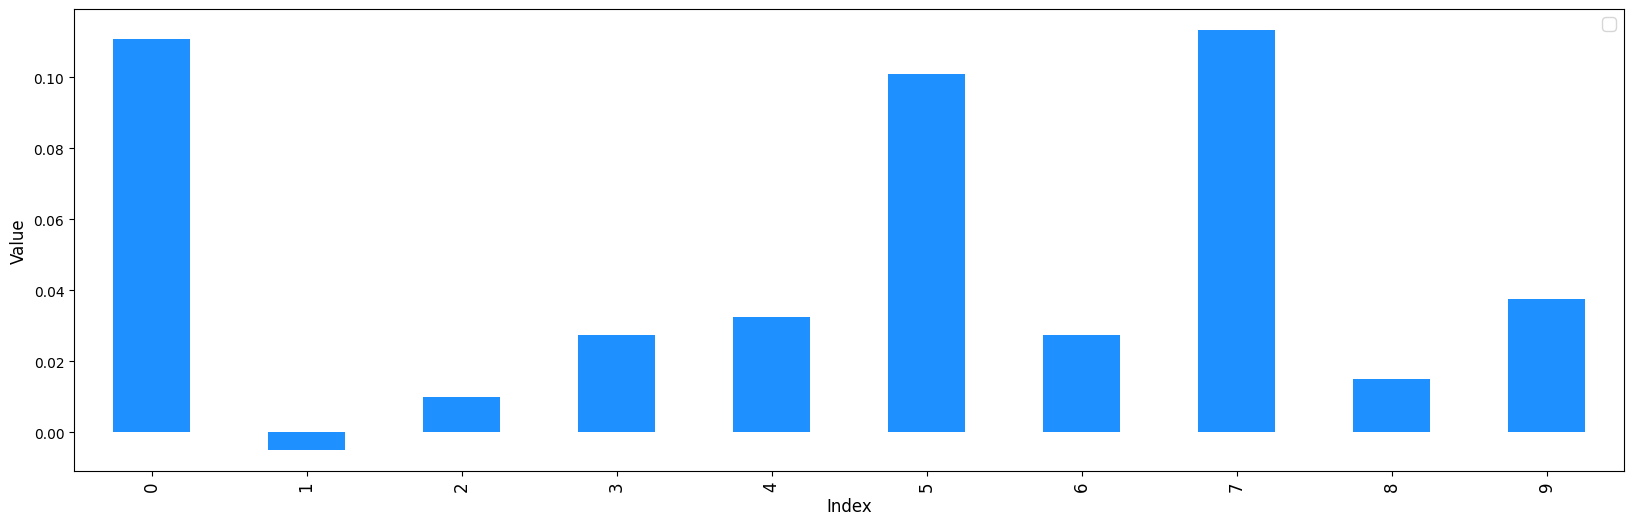

In [175]:
exact_values_df.T.plot.bar(xlabel="Index", ylabel="Value", color=["dodgerblue"])
plt.legend([]);

In [185]:
budget_array = np.linspace(200, 2 ** (len(small_dataset) - 1), num=10, dtype=int)

all_estimated_values_df = []

for budget in budget_array:
    dfs = []
    for i in range(50):
        estimated_values = montecarlo_least_core(
            u=utility, max_iterations=budget, progress=False
        )
        df = pd.DataFrame([estimated_values.values()], columns=estimated_values.keys())
        df = df[sorted(df.columns)]
        df["budget"] = budget
        dfs.append(df)
    estimated_values_df = pd.concat(dfs)
    all_estimated_values_df.append(estimated_values_df)

values_df = pd.concat(all_estimated_values_df)

In [192]:
errors_df = values_df.groupby("budget", group_keys=True).apply(
    lambda x: x.drop(columns=["budget"]).apply(
        lambda k: mean_squared_error(exact_values_df.T, k), axis=1
    )
)
mean_errors_df = errors_df.mean(axis=1)
std_errors_df = errors_df.std(axis=1)

In [193]:
errors_df

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
budget,,,,,,,,,,,,,,,,,,,,,
200,0.001990,0.000725,0.000370,0.001254,0.000105,0.000348,0.000314,0.000273,0.000120,0.000110,...,0.000219,0.000281,0.000252,0.000083,0.000367,0.000555,0.000172,0.000377,0.000140,0.000159
234,0.000139,0.000252,0.000113,0.000233,0.000334,0.000161,0.000049,0.000348,0.000436,0.000356,...,0.000424,0.000115,0.000176,0.000155,0.000101,0.000268,0.000151,0.000270,0.000393,0.000350
269,0.000175,0.000376,0.000113,0.000129,0.000374,0.000147,0.000429,0.000307,0.000784,0.000343,...,0.000323,0.000233,0.000183,0.000410,0.000200,0.000320,0.000370,0.000497,0.000064,0.000352
304,0.000402,0.000664,0.000498,0.000335,0.000201,0.000162,0.000615,0.000109,0.000172,0.000277,...,0.000170,0.000474,0.000181,0.000421,0.000373,0.000207,0.000077,0.000222,0.000222,0.000159
338,0.001469,0.000182,0.000502,0.000317,0.000197,0.000284,0.000448,0.000142,0.000867,0.000143,...,0.000075,0.000196,0.000131,0.000109,0.000648,0.000168,0.000253,0.000351,0.000371,0.000102
373,0.000207,0.000161,0.000085,0.000108,0.000181,0.000178,0.000612,0.000558,0.000268,0.000066,...,0.000282,0.000095,0.000228,0.000206,0.000086,0.000174,0.000737,0.000246,0.000113,0.000159
408,0.000095,0.000103,0.000254,0.000108,0.000195,0.000056,0.000088,0.000190,0.000065,0.000186,...,0.000547,0.000439,0.000182,0.000113,0.000127,0.000106,0.000453,0.000176,0.000094,0.000942
442,0.000162,0.000559,0.000038,0.000056,0.000241,0.000105,0.000769,0.000084,0.000152,0.000088,...,0.000211,0.000451,0.000162,0.000009,0.000105,0.000055,0.000174,0.000324,0.000242,0.000286
477,0.000036,0.000062,0.000134,0.000292,0.000190,0.000181,0.000139,0.000071,0.000117,0.000133,...,0.000077,0.000086,0.000265,0.000104,0.000041,0.000151,0.000211,0.000066,0.000175,0.000164


In [190]:
from pydvl.reporting.plots import shaded_mean_std

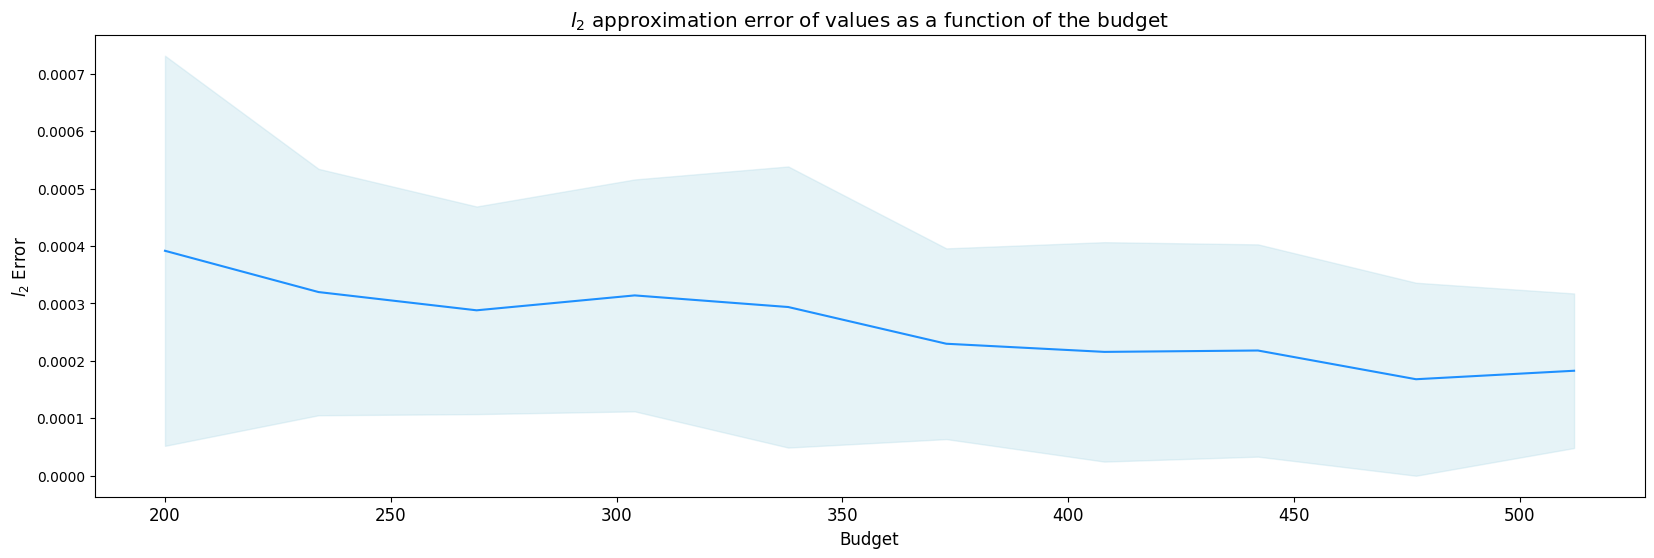

In [195]:
ax = shaded_mean_std(
    errors_df.transpose(),
    abscissa=errors_df.index,
    num_std=1,
    xlabel="Budget",
    ylabel="$l_2$ Error",
    label="Estimated values",
    title="$l_2$ approximation error of values as a function of the budget",
)

We can see that increasing the budget does not necessarily mean that the error will decrease. This is due to the fact that we sample the subsets randomly in the Monte Carlo method and that there may be repeated subsets. 

In [196]:
best_budget = mean_errors_df.index[mean_errors_df.argmin()]
best_iteration_df = (
    values_df[values_df["budget"] == best_budget].drop(columns=["budget"]).sample(1)
)

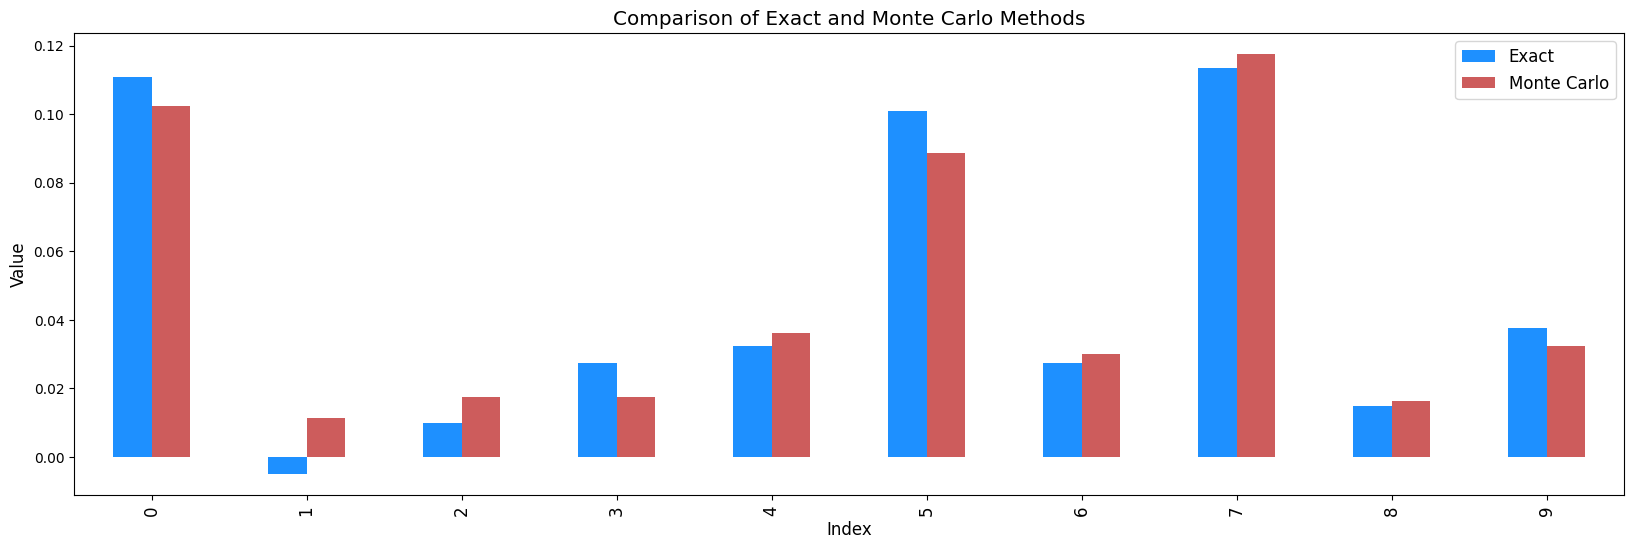

In [197]:
pd.concat([exact_values_df, best_iteration_df]).T.plot.bar(
    title="Comparison of Exact and Monte Carlo Methods",
    xlabel="Index",
    ylabel="Value",
    color=["dodgerblue", "indianred"],
)
plt.legend(["Exact", "Monte Carlo"]);

## Data Removal

In [198]:
utility = Utility(model=model, data=full_dataset, enable_cache=False)

### Remove Best

In [96]:
budget_array = np.array([5000, 10000, 25000, 50000])
budget_array

array([ 5000, 10000, 25000, 50000])

In [ ]:
all_estimated_values_df = []

for budget in budget_array:
    dfs = []
    for i in range(10):
        estimated_values = montecarlo_least_core(
            u=utility, max_iterations=budget, progress=False
        )
        df = pd.DataFrame([estimated_values.values()], columns=estimated_values.keys())
        df["max_iterations"] = max_iterations
        dfs.append(df)
    estimated_values_df = pd.concat(dfs)
    all_estimated_values_df.append(estimated_values_df)

### Remove Worst